ПРОВЕРКА GPU
TensorFlow version: 2.10.1
Доступные GPU: []
⚠ GPU не найден! Обучение будет ОЧЕНЬ медленным.
Включите GPU в Kaggle: Settings -> Accelerator -> GPU T4 x2

Параметры спектрограмм:
- Sampling Rate: 16000 Hz
- N_MELS: 128
- HOP_LENGTH: 512
- N_FFT: 2048
- MAX_TIME_STEPS: 128

Загружено файлов: 2499
Уникальных говорящих: 49


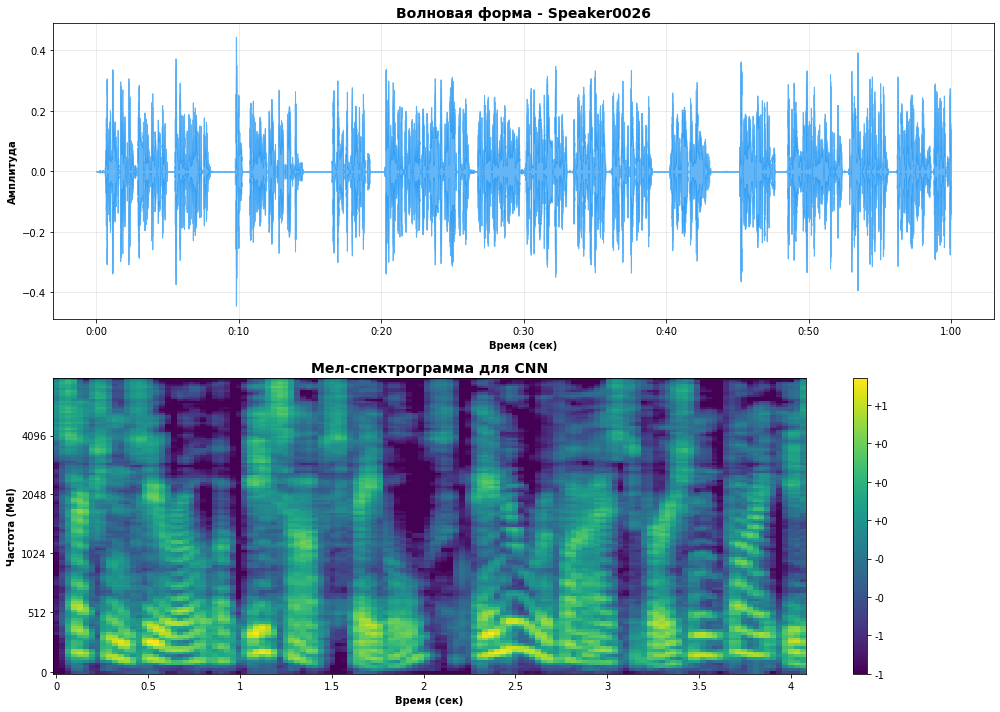


Генерация датасета спектрограмм...
Это может занять время (обрабатывается весь датасет)


100%|██████████| 2499/2499 [02:16<00:00, 18.26it/s]



✓ Форма датасета спектрограмм: (2499, 128, 128, 1)
✓ Количество меток: 2499
✓ Количество классов: 49

Тренировочная выборка: (1999, 128, 128, 1)
Тестовая выборка: (500, 128, 128, 1)

АРХИТЕКТУРА CNN
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 128, 128, 32)      320       
                                                                 
 batch_normalization_12 (Bat  (None, 128, 128, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 64, 64, 32)        0         
                                                    

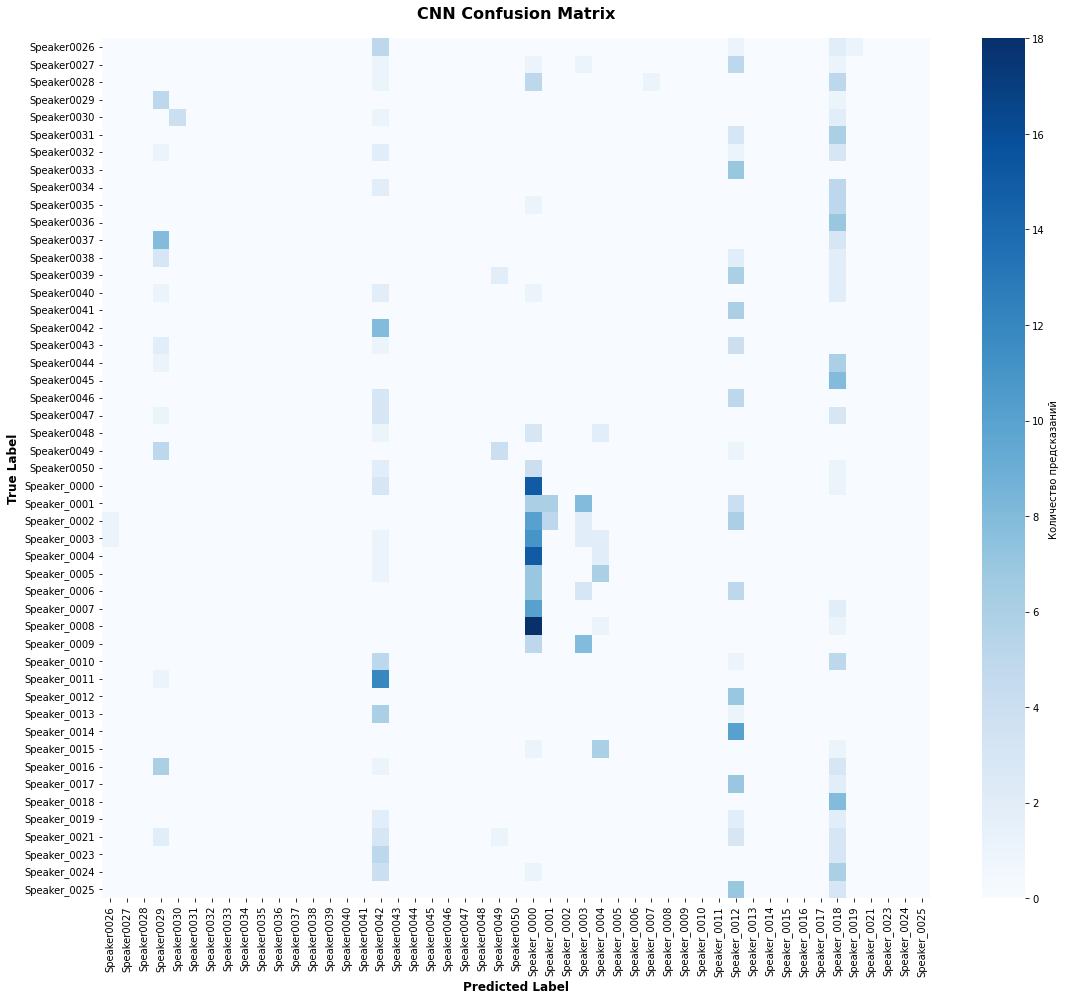

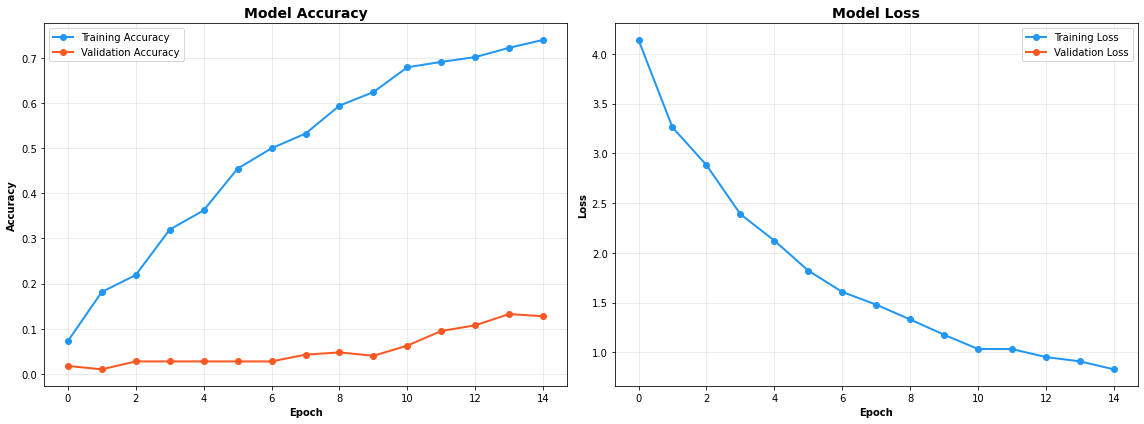


АНАЛИЗ ПЕРЕОБУЧЕНИЯ CNN
Final Training Accuracy: 0.7398
Final Validation Accuracy: 0.1275
Gap (Train - Val): 0.6123
Test Accuracy: 0.1220
✗ Уровень переобучения: КРИТИЧЕСКОЕ


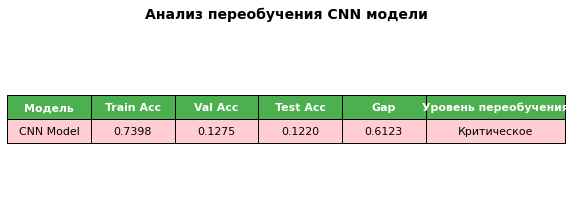


СРАВНЕНИЕ CNN С ТРАДИЦИОННЫМИ МОДЕЛЯМИ
             Model  Test_Acc      Gap
               SVM     0.978 0.022000
LogisticRegression     0.978 0.015997
               KNN     0.974 0.026000
      RandomForest     0.970 0.030000
        NaiveBayes     0.960 0.020490
  GradientBoosting     0.930 0.070000
      DecisionTree     0.856 0.143500
CNN (Spectrograms)     0.122 0.612337


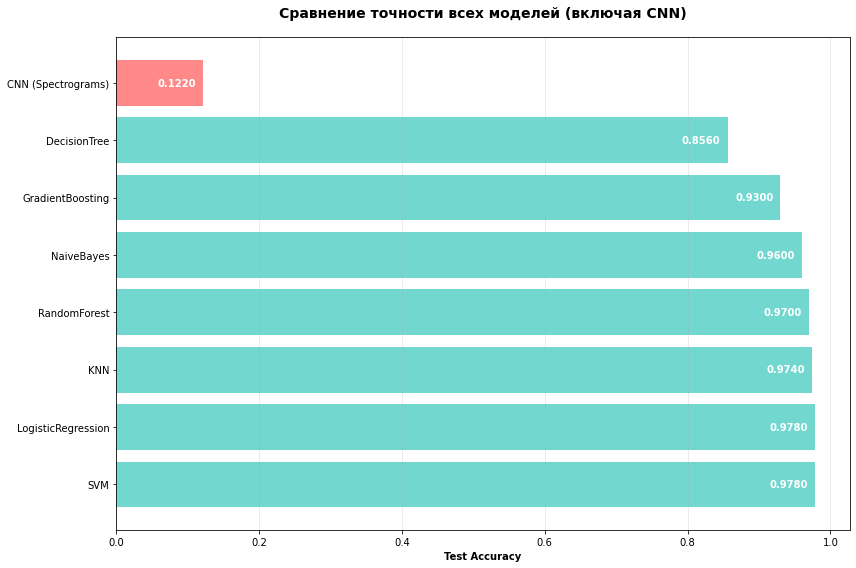


ЭТАП 4 ЗАВЕРШЕН: CNN на спектрограммах
✓ Сохранены артефакты:
  - Модель: best_cnn_model.h5
  - Label Encoder: cnn_label_encoder.pkl
  - Параметры спектрограмм: spectrogram_params.pkl
  - История обучения: cnn_training_history.csv
  - Результаты: cnn_results.csv
  - Графики: все PNG файлы

✓ CNN Test Accuracy: 0.1220
✓ Gap: 0.6123
✓ Обучено эпох: 15

ВСЕ МОДЕЛИ ГОТОВЫ ДЛЯ ИНТЕГРАЦИИ В ВЕБ-СЕРВИС!

Следующие шаги:
1. Скачайте все .pkl и .h5 файлы из Kaggle
2. Загрузите их на HuggingFace Hub или Google Drive
3. Интегрируйте в Backend API (FastAPI)
4. Разверните веб-приложение


In [3]:
"""
KAGGLE NOTEBOOK 4: CNN на мел-спектрограммах

"""

import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# ПРОВЕРКА GPU И НАСТРОЙКА TENSORFLOW
# ============================================================================

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import joblib

print("="*80)
print("ПРОВЕРКА GPU")
print("="*80)
print(f"TensorFlow version: {tf.__version__}")
print(f"Доступные GPU: {tf.config.list_physical_devices('GPU')}")

# Настройка использования GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✓ GPU настроен, найдено устройств: {len(gpus)}")
    except RuntimeError as e:
        print(f"Ошибка настройки GPU: {e}")
else:
    print("⚠ GPU не найден! Обучение будет ОЧЕНЬ медленным.")
    print("Включите GPU в Kaggle: Settings -> Accelerator -> GPU T4 x2")

# ============================================================================
# 1. ПАРАМЕТРЫ - ВАШ ВЫБОР
# ============================================================================

SR = 16000  # Sampling rate из вашего кода
N_MELS = 128  # Количество мел-фильтров
HOP_LENGTH = 512
N_FFT = 2048
MAX_TIME_STEPS = 128  # Фиксированная длина спектрограммы

print(f"\nПараметры спектрограмм:")
print(f"- Sampling Rate: {SR} Hz")
print(f"- N_MELS: {N_MELS}")
print(f"- HOP_LENGTH: {HOP_LENGTH}")
print(f"- N_FFT: {N_FFT}")
print(f"- MAX_TIME_STEPS: {MAX_TIME_STEPS}")

# ============================================================================
# 2. ЗАГРУЗКА ДАННЫХ - ВАШ СПОСОБ
# ============================================================================

df_filtered = pd.read_csv(r'D:\VKR\filtered_dataset.csv')
print(f"\nЗагружено файлов: {len(df_filtered)}")
print(f"Уникальных говорящих: {df_filtered['speaker_id'].nunique()}")

# ============================================================================
# 3. ФУНКЦИЯ ГЕНЕРАЦИИ МЕЛ-СПЕКТРОГРАММ
# ============================================================================

def audio_to_melspectrogram(file_path, sr=SR, n_mels=N_MELS, 
                           max_time_steps=MAX_TIME_STEPS):
    """
    Преобразует аудиофайл в мел-спектрограмму фиксированного размера
    Основано на вашем коде обработки аудио
    """
    try:
        # Загружаем аудио (ваш способ)
        y, _ = librosa.load(file_path, sr=sr)
        
        # Убираем тишину (как в вашем extract_features)
        y, _ = librosa.effects.trim(y, top_db=20)
        
        # Генерируем мел-спектрограмму
        mel_spec = librosa.feature.melspectrogram(
            y=y, sr=sr, n_mels=n_mels,
            hop_length=HOP_LENGTH, n_fft=N_FFT
        )
        
        # Преобразуем в децибелы
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        
        # Нормализация [-1, 1]
        mel_spec_norm = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min())
        mel_spec_norm = 2 * mel_spec_norm - 1
        
        # Приводим к фиксированной длине
        if mel_spec_norm.shape[1] < max_time_steps:
            # Padding
            pad_width = max_time_steps - mel_spec_norm.shape[1]
            mel_spec_norm = np.pad(mel_spec_norm, ((0, 0), (0, pad_width)), mode='constant')
        else:
            # Truncate
            mel_spec_norm = mel_spec_norm[:, :max_time_steps]
        
        return mel_spec_norm
        
    except Exception as e:
        print(f"Ошибка обработки {file_path}: {e}")
        return None

# Визуализация примера - ВАШ СТИЛЬ
sample_file = df_filtered['file_path'].iloc[0]
sample_speaker = df_filtered['speaker_id'].iloc[0]

y, sr = librosa.load(sample_file, sr=SR)
mel_spec = audio_to_melspectrogram(sample_file)

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Волновая форма
librosa.display.waveshow(y, sr=sr, ax=axes[0], color='#2196F3', alpha=0.7)
axes[0].set_title(f'Волновая форма - {sample_speaker}', fontweight='bold', fontsize=14)
axes[0].set_xlabel('Время (сек)', fontweight='bold')
axes[0].set_ylabel('Амплитуда', fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Мел-спектрограмма
img = librosa.display.specshow(mel_spec, x_axis='time', y_axis='mel', 
                               sr=sr, hop_length=HOP_LENGTH, ax=axes[1], cmap='viridis')
axes[1].set_title('Мел-спектрограмма для CNN', fontweight='bold', fontsize=14)
axes[1].set_xlabel('Время (сек)', fontweight='bold')
axes[1].set_ylabel('Частота (Mel)', fontweight='bold')
fig.colorbar(img, ax=axes[1], format='%+2.0f')

plt.tight_layout()
plt.savefig('sample_melspectrogram.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# 4. СОЗДАНИЕ ДАТАСЕТА СПЕКТРОГРАММ
# ============================================================================

print("\nГенерация датасета спектрограмм...")
print("Это может занять время (обрабатывается весь датасет)")

spectrograms = []
labels = []

for idx, row in tqdm(df_filtered.iterrows(), total=len(df_filtered)):
    mel_spec = audio_to_melspectrogram(row['file_path'])
    
    if mel_spec is not None:
        spectrograms.append(mel_spec)
        labels.append(row['speaker_id'])

# Конвертируем в numpy arrays
X_spec = np.array(spectrograms)
y_spec = np.array(labels)

# Добавляем канальное измерение для CNN (как изображения)
X_spec = X_spec[..., np.newaxis]  # (samples, n_mels, time_steps, 1)

print(f"\n✓ Форма датасета спектрограмм: {X_spec.shape}")
print(f"✓ Количество меток: {len(y_spec)}")

# Кодируем метки
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_spec)
num_classes = len(label_encoder.classes_)

print(f"✓ Количество классов: {num_classes}")

# ============================================================================
# 5. РАЗДЕЛЕНИЕ ДАННЫХ - ВАШ КОД
# ============================================================================

X_train, X_test, y_train, y_test = train_test_split(
    X_spec, y_encoded, 
    test_size=0.2, 
    random_state=42,
    stratify=y_encoded
)

print(f"\nТренировочная выборка: {X_train.shape}")
print(f"Тестовая выборка: {X_test.shape}")

# ============================================================================
# 6. ПОСТРОЕНИЕ CNN МОДЕЛИ
# ============================================================================

def build_cnn_model(input_shape, num_classes):
    """
    Архитектура CNN для классификации спектрограмм
    Оптимизирована для GPU
    """
    model = models.Sequential([
        # Conv Block 1
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Conv Block 2
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Conv Block 3
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Conv Block 4
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),
        
        # Dense Layers
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        # Output
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

input_shape = (N_MELS, MAX_TIME_STEPS, 1)
model = build_cnn_model(input_shape, num_classes)

print("\n" + "="*80)
print("АРХИТЕКТУРА CNN")
print("="*80)
model.summary()

# ============================================================================
# 7. КОМПИЛЯЦИЯ И CALLBACKS
# ============================================================================

# Компиляция с оптимизатором Adam
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks для улучшения обучения
checkpoint_cb = callbacks.ModelCheckpoint(
    'best_cnn_model.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

early_stopping_cb = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr_cb = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

# ============================================================================
# 8. ОБУЧЕНИЕ МОДЕЛИ НА GPU
# ============================================================================

EPOCHS = 100
BATCH_SIZE = 32

print("\n" + "="*80)
print("НАЧАЛО ОБУЧЕНИЯ CNN НА GPU")
print("="*80)
print(f"Epochs: {EPOCHS}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Training Samples: {len(X_train)}")
print(f"Validation Split: 20%")
print("="*80)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr_cb],
    verbose=1
)

# ============================================================================
# 9. ОЦЕНКА МОДЕЛИ
# ============================================================================

# Загружаем лучшую модель
best_model = keras.models.load_model('best_cnn_model.h5')

# Оценка на тестовой выборке
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=1)

print("\n" + "="*80)
print("РЕЗУЛЬТАТЫ CNN")
print("="*80)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Предсказания
y_pred_proba = best_model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

# Метрики
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("\nClassification Report:")
print(classification_report(y_test, y_pred, 
                          target_names=label_encoder.classes_,
                          digits=4))

# ВАША Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(16, 14))
import seaborn as sns
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Количество предсказаний'})
plt.title('CNN Confusion Matrix', fontweight='bold', fontsize=16, pad=20)
plt.xlabel('Predicted Label', fontweight='bold', fontsize=12)
plt.ylabel('True Label', fontweight='bold', fontsize=12)
plt.tight_layout()
plt.savefig('cnn_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# 10. ВИЗУАЛИЗАЦИЯ ОБУЧЕНИЯ - ВАШ СТИЛЬ
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Accuracy
axes[0].plot(history.history['accuracy'], 'o-', color='#2196F3', 
            label='Training Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], 'o-', color='#FF5722',
            label='Validation Accuracy', linewidth=2)
axes[0].set_xlabel('Epoch', fontweight='bold')
axes[0].set_ylabel('Accuracy', fontweight='bold')
axes[0].set_title('Model Accuracy', fontweight='bold', fontsize=14)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Loss
axes[1].plot(history.history['loss'], 'o-', color='#2196F3',
            label='Training Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], 'o-', color='#FF5722',
            label='Validation Loss', linewidth=2)
axes[1].set_xlabel('Epoch', fontweight='bold')
axes[1].set_ylabel('Loss', fontweight='bold')
axes[1].set_title('Model Loss', fontweight='bold', fontsize=14)
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('cnn_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# 11. АНАЛИЗ ПЕРЕОБУЧЕНИЯ CNN
# ============================================================================

train_acc_final = history.history['accuracy'][-1]
val_acc_final = history.history['val_accuracy'][-1]
gap = train_acc_final - val_acc_final

print("\n" + "="*80)
print("АНАЛИЗ ПЕРЕОБУЧЕНИЯ CNN")
print("="*80)
print(f"Final Training Accuracy: {train_acc_final:.4f}")
print(f"Final Validation Accuracy: {val_acc_final:.4f}")
print(f"Gap (Train - Val): {gap:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

if gap < 0.02:
    print("✓ Уровень переобучения: МИНИМАЛЬНОЕ")
elif gap < 0.05:
    print("⚠ Уровень переобучения: УМЕРЕННОЕ")
else:
    print("✗ Уровень переобучения: КРИТИЧЕСКОЕ")

# Визуализация в стиле вашей таблицы
fig, ax = plt.subplots(figsize=(10, 3))
ax.axis('tight')
ax.axis('off')

table_data = [
    ['CNN Model', f'{train_acc_final:.4f}', f'{val_acc_final:.4f}', 
     f'{test_acc:.4f}', f'{gap:.4f}',
     'Минимальное' if gap < 0.02 else ('Умеренное' if gap < 0.05 else 'Критическое')]
]

table = ax.table(cellText=table_data,
                colLabels=['Модель', 'Train Acc', 'Val Acc', 'Test Acc', 'Gap', 'Уровень переобучения'],
                cellLoc='center',
                loc='center',
                colWidths=[0.15, 0.15, 0.15, 0.15, 0.15, 0.25])

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2)

# Раскрашиваем
for i in range(6):
    table[(0, i)].set_facecolor('#4CAF50')
    table[(0, i)].set_text_props(weight='bold', color='white')

color = '#C8E6C9' if gap < 0.02 else ('#FFE082' if gap < 0.05 else '#FFCDD2')
for j in range(6):
    table[(1, j)].set_facecolor(color)

plt.title('Анализ переобучения CNN модели', fontweight='bold', fontsize=14, pad=20)
plt.savefig('cnn_overfitting_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# 12. СРАВНЕНИЕ С ТРАДИЦИОННЫМИ МОДЕЛЯМИ
# ============================================================================

# Загружаем результаты традиционных моделей
traditional_results = pd.read_csv(r'D:\VKR\model_results.csv')

# Добавляем результаты CNN
cnn_results = pd.DataFrame([{
    'Model': 'CNN (Spectrograms)',
    'Train_Acc': train_acc_final,
    'Test_Acc': test_acc,
    'Gap': gap
}])

comparison = pd.concat([traditional_results[['Model', 'Test_Acc', 'Gap']], 
                       cnn_results[['Model', 'Test_Acc', 'Gap']]], 
                       ignore_index=True)
comparison = comparison.sort_values('Test_Acc', ascending=False)

print("\n" + "="*80)
print("СРАВНЕНИЕ CNN С ТРАДИЦИОННЫМИ МОДЕЛЯМИ")
print("="*80)
print(comparison.to_string(index=False))

# Визуализация сравнения - ВАШ СТИЛЬ
fig, ax = plt.subplots(figsize=(12, 8))
colors = ['#FF6B6B' if model == 'CNN (Spectrograms)' else '#4ECDC4' 
          for model in comparison['Model']]
bars = ax.barh(comparison['Model'], comparison['Test_Acc'], color=colors, alpha=0.8)

ax.set_xlabel('Test Accuracy', fontweight='bold')
ax.set_title('Сравнение точности всех моделей (включая CNN)', fontweight='bold', fontsize=14, pad=20)
ax.grid(axis='x', alpha=0.3)

# Добавляем значения
for bar, value in zip(bars, comparison['Test_Acc']):
    ax.text(value - 0.01, bar.get_y() + bar.get_height()/2, 
            f'{value:.4f}', va='center', ha='right', fontweight='bold', color='white')

plt.tight_layout()
plt.savefig('all_models_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# 13. СОХРАНЕНИЕ АРТЕФАКТОВ
# ============================================================================

# Сохраняем label encoder для CNN
joblib.dump(label_encoder, 'cnn_label_encoder.pkl')

# Сохраняем параметры спектрограмм
spectrogram_params = {
    'sr': SR,
    'n_mels': N_MELS,
    'hop_length': HOP_LENGTH,
    'n_fft': N_FFT,
    'max_time_steps': MAX_TIME_STEPS
}
joblib.dump(spectrogram_params, 'spectrogram_params.pkl')

# Сохраняем историю обучения
history_df = pd.DataFrame(history.history)
history_df.to_csv('cnn_training_history.csv', index=False)

# Сохраняем результаты CNN
cnn_full_results = pd.DataFrame([{
    'Model': 'CNN',
    'Train_Acc': train_acc_final,
    'Val_Acc': val_acc_final,
    'Test_Acc': test_acc,
    'Test_Loss': test_loss,
    'Gap': gap,
    'Epochs_Trained': len(history.history['accuracy'])
}])
cnn_full_results.to_csv('cnn_results.csv', index=False)

print("\n" + "="*80)
print("ЭТАП 4 ЗАВЕРШЕН: CNN на спектрограммах")
print("="*80)
print("✓ Сохранены артефакты:")
print("  - Модель: best_cnn_model.h5")
print("  - Label Encoder: cnn_label_encoder.pkl")
print("  - Параметры спектрограмм: spectrogram_params.pkl")
print("  - История обучения: cnn_training_history.csv")
print("  - Результаты: cnn_results.csv")
print("  - Графики: все PNG файлы")
print(f"\n✓ CNN Test Accuracy: {test_acc:.4f}")
print(f"✓ Gap: {gap:.4f}")
print(f"✓ Обучено эпох: {len(history.history['accuracy'])}")
print("\n" + "="*80)
print("ВСЕ МОДЕЛИ ГОТОВЫ ДЛЯ ИНТЕГРАЦИИ В ВЕБ-СЕРВИС!")
print("="*80)
print("\nСледующие шаги:")
print("1. Скачайте все .pkl и .h5 файлы из Kaggle")
print("2. Загрузите их на HuggingFace Hub или Google Drive")
print("3. Интегрируйте в Backend API (FastAPI)")
print("4. Разверните веб-приложение")
print("="*80)

ПРОВЕРКА GPU
TensorFlow: 2.10.1
GPU доступно: []
⚠ GPU НЕ НАЙДЕН! Включите в Settings -> Accelerator -> GPU T4 x2
Без GPU обучение займёт ЧАСЫ!

Параметры:
- Sample Rate: 16000 Hz
- N_MELS: 128
- Длина спектрограммы: 216 временных шагов (~7s)

✓ Загружено файлов: 2499
✓ Уникальных говорящих: 49

Визуализация спектрограммы...
✓ Размер спектрограммы: (128, 216)


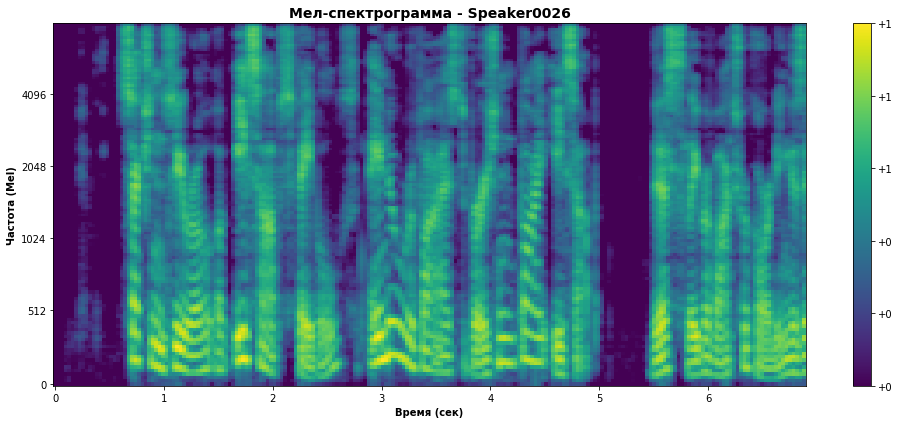


ГЕНЕРАЦИЯ ДАТАСЕТА СПЕКТРОГРАММ
Это займёт время, наберитесь терпения...


Обработка: 100%|██████████| 2499/2499 [00:23<00:00, 104.27it/s]



✓ Успешно обработано: 2499
✗ Ошибок: 0

✓ Форма датасета: (2499, 128, 216, 1)
  - Образцов: 2499
  - Высота (mel bins): 128
  - Ширина (время): 216
  - Каналы: 1
✓ Классов (говорящих): 49

✓ Train: (1999, 128, 216, 1)
✓ Test: (500, 128, 216, 1)
✓ Веса классов вычислены (для борьбы с дисбалансом)

АРХИТЕКТУРА CNN
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 128, 216, 32)      320       
                                                                 
 batch_normalization_18 (Bat  (None, 128, 216, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_13 (Conv2D)          (None, 128, 216, 32)      9248      
                                                                 
 batch_normalization_19 (Bat  (None, 128, 216, 32)     128       
 ch

KeyboardInterrupt: 

In [5]:
"""
KAGGLE NOTEBOOK 4: CNN на мел-спектрограммах - ИСПРАВЛЕННАЯ ВЕРСИЯ
ТРЕБУЕТ GPU! Settings -> Accelerator -> GPU T4 x2

ЦЕЛЬ: Улучшить распознавание говорящих с нестандартными акцентами
через анализ спектрограмм (как изображений)
"""

import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# GPU ПРОВЕРКА И НАСТРОЙКА
# ============================================================================

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks, regularizers
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import joblib

print("="*80)
print("ПРОВЕРКА GPU")
print("="*80)
print(f"TensorFlow: {tf.__version__}")
print(f"GPU доступно: {tf.config.list_physical_devices('GPU')}")

# Настройка GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✓ GPU настроен: {len(gpus)} устройств")
    except RuntimeError as e:
        print(f"Ошибка GPU: {e}")
else:
    print("⚠ GPU НЕ НАЙДЕН! Включите в Settings -> Accelerator -> GPU T4 x2")
    print("Без GPU обучение займёт ЧАСЫ!")

# ============================================================================
# 1. ПАРАМЕТРЫ СПЕКТРОГРАММ
# ============================================================================

SR = 16000
N_MELS = 128
HOP_LENGTH = 512
N_FFT = 2048
MAX_TIME_STEPS = 216  # ~7 секунд аудио (увеличил с 128)
DURATION = 7  # секунд

print(f"\nПараметры:")
print(f"- Sample Rate: {SR} Hz")
print(f"- N_MELS: {N_MELS}")
print(f"- Длина спектрограммы: {MAX_TIME_STEPS} временных шагов (~{DURATION}s)")

# ============================================================================
# 2. ЗАГРУЗКА ДАННЫХ
# ============================================================================

df_filtered = pd.read_csv(r'D:\VKR\filtered_dataset.csv')
print(f"\n✓ Загружено файлов: {len(df_filtered)}")
print(f"✓ Уникальных говорящих: {df_filtered['speaker_id'].nunique()}")

# ============================================================================
# 3. ФУНКЦИЯ ГЕНЕРАЦИИ МЕЛ-СПЕКТРОГРАММ (ИСПРАВЛЕННАЯ)
# ============================================================================

def audio_to_melspectrogram(file_path, sr=SR, n_mels=N_MELS, 
                           max_time_steps=MAX_TIME_STEPS, duration=DURATION):
    """
    Преобразует аудио в мел-спектрограмму
    ИСПРАВЛЕНО: правильная обработка длительности
    """
    try:
        # Загружаем ТОЧНО duration секунд
        y, _ = librosa.load(file_path, sr=sr, duration=duration)
        
        # Если короче, дополняем нулями
        if len(y) < sr * duration:
            y = np.pad(y, (0, sr * duration - len(y)), mode='constant')
        
        # Генерируем мел-спектрограмму
        mel_spec = librosa.feature.melspectrogram(
            y=y, sr=sr, n_mels=n_mels,
            hop_length=HOP_LENGTH, 
            n_fft=N_FFT,
            fmax=8000  # Голосовые частоты до 8kHz
        )
        
        # В децибелы
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        
        # Нормализация в [0, 1]
        mel_spec_norm = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min() + 1e-8)
        
        # Проверяем размер
        if mel_spec_norm.shape[1] != max_time_steps:
            # Resize до нужного размера
            if mel_spec_norm.shape[1] < max_time_steps:
                pad_width = max_time_steps - mel_spec_norm.shape[1]
                mel_spec_norm = np.pad(mel_spec_norm, ((0, 0), (0, pad_width)), mode='constant')
            else:
                mel_spec_norm = mel_spec_norm[:, :max_time_steps]
        
        return mel_spec_norm
        
    except Exception as e:
        print(f"Ошибка {file_path}: {e}")
        return None

# Визуализация примера
print("\nВизуализация спектрограммы...")
sample_file = df_filtered['file_path'].iloc[0]
sample_speaker = df_filtered['speaker_id'].iloc[0]

mel_spec = audio_to_melspectrogram(sample_file)
print(f"✓ Размер спектрограммы: {mel_spec.shape}")

fig, ax = plt.subplots(figsize=(14, 6))
img = librosa.display.specshow(mel_spec, x_axis='time', y_axis='mel', 
                               sr=SR, hop_length=HOP_LENGTH, ax=ax, cmap='viridis')
ax.set_title(f'Мел-спектрограмма - {sample_speaker}', fontweight='bold', fontsize=14)
ax.set_xlabel('Время (сек)', fontweight='bold')
ax.set_ylabel('Частота (Mel)', fontweight='bold')
fig.colorbar(img, ax=ax, format='%+2.0f')
plt.tight_layout()
plt.savefig('melspectrogram_example.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# 4. ГЕНЕРАЦИЯ ДАТАСЕТА (С ПРОГРЕСС-БАРОМ)
# ============================================================================

print("\n" + "="*80)
print("ГЕНЕРАЦИЯ ДАТАСЕТА СПЕКТРОГРАММ")
print("="*80)
print("Это займёт время, наберитесь терпения...")

spectrograms = []
labels = []
failed_count = 0

for idx, row in tqdm(df_filtered.iterrows(), total=len(df_filtered), desc="Обработка"):
    mel_spec = audio_to_melspectrogram(row['file_path'])
    
    if mel_spec is not None:
        spectrograms.append(mel_spec)
        labels.append(row['speaker_id'])
    else:
        failed_count += 1

print(f"\n✓ Успешно обработано: {len(spectrograms)}")
print(f"✗ Ошибок: {failed_count}")

# Конвертируем в numpy
X_spec = np.array(spectrograms)
y_spec = np.array(labels)

# Добавляем канальное измерение (как RGB изображение, но 1 канал)
X_spec = X_spec[..., np.newaxis]

print(f"\n✓ Форма датасета: {X_spec.shape}")
print(f"  - Образцов: {X_spec.shape[0]}")
print(f"  - Высота (mel bins): {X_spec.shape[1]}")
print(f"  - Ширина (время): {X_spec.shape[2]}")
print(f"  - Каналы: {X_spec.shape[3]}")

# Кодируем метки
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_spec)
num_classes = len(label_encoder.classes_)

print(f"✓ Классов (говорящих): {num_classes}")

# ============================================================================
# 5. РАЗДЕЛЕНИЕ ДАННЫХ
# ============================================================================

X_train, X_test, y_train, y_test = train_test_split(
    X_spec, y_encoded, 
    test_size=0.2, 
    random_state=42,
    stratify=y_encoded
)

print(f"\n✓ Train: {X_train.shape}")
print(f"✓ Test: {X_test.shape}")

# Вычисляем веса классов (для борьбы с дисбалансом)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))
print(f"✓ Веса классов вычислены (для борьбы с дисбалансом)")

# ============================================================================
# 6. CNN АРХИТЕКТУРА (ИСПРАВЛЕННАЯ)
# ============================================================================

def build_cnn_improved(input_shape, num_classes):
    """
    Улучшенная CNN для анализа спектрограмм
    Inspired by VGGNet с адаптацией под аудио
    """
    
    model = models.Sequential([
        # Input
        layers.Input(shape=input_shape),
        
        # Block 1: Извлечение низкоуровневых признаков
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Block 2: Средние признаки
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Block 3: Высокоуровневые признаки
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        
        # Block 4: Детальные паттерны
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.4),
        
        # Dense layers
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        
        # Output
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# Создаём модель
input_shape = (N_MELS, MAX_TIME_STEPS, 1)
model = build_cnn_improved(input_shape, num_classes)

print("\n" + "="*80)
print("АРХИТЕКТУРА CNN")
print("="*80)
model.summary()

# ============================================================================
# 7. КОМПИЛЯЦИЯ И CALLBACKS
# ============================================================================

# Оптимизатор с learning rate schedule
initial_learning_rate = 0.001
optimizer = Adam(learning_rate=initial_learning_rate)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
checkpoint_cb = callbacks.ModelCheckpoint(
    'best_cnn_model.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

early_stopping_cb = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,  # Увеличил с 15
    restore_best_weights=True,
    verbose=1
)

reduce_lr_cb = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=7,  # Увеличил с 5
    min_lr=1e-7,
    verbose=1
)

# TensorBoard (опционально)
tensorboard_cb = callbacks.TensorBoard(
    log_dir='./logs',
    histogram_freq=1
)

# ============================================================================
# 8. ОБУЧЕНИЕ НА GPU
# ============================================================================

EPOCHS = 100
BATCH_SIZE = 32

print("\n" + "="*80)
print("ОБУЧЕНИЕ CNN")
print("="*80)
print(f"Epochs: {EPOCHS}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Training: {len(X_train)} образцов")
print(f"Validation: 20% от training")
print("="*80 + "\n")

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=class_weight_dict,  # Используем веса
    callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr_cb],
    verbose=1
)

# ============================================================================
# 9. ОЦЕНКА МОДЕЛИ
# ============================================================================

# Загружаем лучшую модель
best_model = keras.models.load_model('best_cnn_model.h5')

print("\n" + "="*80)
print("ОЦЕНКА НА ТЕСТОВОЙ ВЫБОРКЕ")
print("="*80)

test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=1)

print(f"\n✓ Test Accuracy: {test_acc:.4f}")
print(f"✓ Test Loss: {test_loss:.4f}")

# Предсказания
y_pred_proba = best_model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)

# Детальные метрики
from sklearn.metrics import classification_report, confusion_matrix

print("\nClassification Report:")
print(classification_report(y_test, y_pred, 
                          target_names=label_encoder.classes_,
                          digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(16, 14))
import seaborn as sns
sns.heatmap(cm, annot=False, cmap='Blues', 
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('CNN Confusion Matrix', fontweight='bold', fontsize=16, pad=20)
plt.xlabel('Predicted', fontweight='bold')
plt.ylabel('Actual', fontweight='bold')
plt.tight_layout()
plt.savefig('cnn_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# 10. ВИЗУАЛИЗАЦИЯ ОБУЧЕНИЯ
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Accuracy
axes[0].plot(history.history['accuracy'], 'o-', color='#2196F3', 
            label='Training', linewidth=2, markersize=4)
axes[0].plot(history.history['val_accuracy'], 'o-', color='#FF5722',
            label='Validation', linewidth=2, markersize=4)
axes[0].set_xlabel('Epoch', fontweight='bold')
axes[0].set_ylabel('Accuracy', fontweight='bold')
axes[0].set_title('CNN Accuracy', fontweight='bold', fontsize=14)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Loss
axes[1].plot(history.history['loss'], 'o-', color='#2196F3',
            label='Training', linewidth=2, markersize=4)
axes[1].plot(history.history['val_loss'], 'o-', color='#FF5722',
            label='Validation', linewidth=2, markersize=4)
axes[1].set_xlabel('Epoch', fontweight='bold')
axes[1].set_ylabel('Loss', fontweight='bold')
axes[1].set_title('CNN Loss', fontweight='bold', fontsize=14)
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('cnn_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# 11. АНАЛИЗ ПЕРЕОБУЧЕНИЯ
# ============================================================================

train_acc_final = history.history['accuracy'][-1]
val_acc_final = history.history['val_accuracy'][-1]
gap = train_acc_final - val_acc_final

print("\n" + "="*80)
print("АНАЛИЗ ПЕРЕОБУЧЕНИЯ")
print("="*80)
print(f"Training Accuracy:   {train_acc_final:.4f}")
print(f"Validation Accuracy: {val_acc_final:.4f}")
print(f"Test Accuracy:       {test_acc:.4f}")
print(f"Gap (Train - Val):   {gap:.4f}")

if gap < 0.05:
    print("✓ Переобучение: МИНИМАЛЬНОЕ")
elif gap < 0.10:
    print("⚠ Переобучение: УМЕРЕННОЕ")
else:
    print("✗ Переобучение: КРИТИЧЕСКОЕ")

# ============================================================================
# 12. СРАВНЕНИЕ С ТРАДИЦИОННЫМИ МОДЕЛЯМИ
# ============================================================================

try:
    traditional_results = pd.read_csv(r'D:\VKR\model_results.csv')
    
    print("\n" + "="*80)
    print("СРАВНЕНИЕ CNN С ТРАДИЦИОННЫМИ МОДЕЛЯМИ")
    print("="*80)
    
    comparison = pd.DataFrame([{
        'Model': 'CNN (Spectrograms)',
        'Accuracy': test_acc,
        'Gap': gap
    }])
    
    full_comparison = pd.concat([
        traditional_results[['Model', 'Accuracy']],
        comparison[['Model', 'Accuracy']]
    ], ignore_index=True).sort_values('Accuracy', ascending=False)
    
    print(full_comparison.to_string(index=False))
    
    # График сравнения
    fig, ax = plt.subplots(figsize=(12, 6))
    colors = ['#FF6B6B' if 'CNN' in m else '#4ECDC4' for m in full_comparison['Model']]
    bars = ax.barh(full_comparison['Model'], full_comparison['Accuracy'], 
                   color=colors, alpha=0.8)
    
    ax.set_xlabel('Test Accuracy', fontweight='bold')
    ax.set_title('Сравнение всех моделей', fontweight='bold', fontsize=14)
    ax.grid(axis='x', alpha=0.3)
    
    for bar, value in zip(bars, full_comparison['Accuracy']):
        ax.text(value - 0.02, bar.get_y() + bar.get_height()/2, 
                f'{value:.4f}', va='center', ha='right', 
                fontweight='bold', color='white')
    
    plt.tight_layout()
    plt.savefig('all_models_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
except FileNotFoundError:
    print("⚠ Файл model_results.csv не найден, пропускаем сравнение")

# ============================================================================
# 13. СОХРАНЕНИЕ АРТЕФАКТОВ
# ============================================================================

joblib.dump(label_encoder, 'cnn_label_encoder.pkl')

spectrogram_params = {
    'sr': SR,
    'n_mels': N_MELS,
    'hop_length': HOP_LENGTH,
    'n_fft': N_FFT,
    'max_time_steps': MAX_TIME_STEPS,
    'duration': DURATION
}
joblib.dump(spectrogram_params, 'spectrogram_params.pkl')

history_df = pd.DataFrame(history.history)
history_df.to_csv('cnn_training_history.csv', index=False)

cnn_results = pd.DataFrame([{
    'Model': 'CNN',
    'Train_Acc': train_acc_final,
    'Val_Acc': val_acc_final,
    'Test_Acc': test_acc,
    'Test_Loss': test_loss,
    'Gap': gap,
    'Epochs_Trained': len(history.history['accuracy']),
    'Best_Val_Acc': max(history.history['val_accuracy'])
}])
cnn_results.to_csv('cnn_results.csv', index=False)

print("\n" + "="*80)
print("✓ ОБУЧЕНИЕ CNN ЗАВЕРШЕНО")
print("="*80)
print("Сохранённые файлы:")
print("  - best_cnn_model.h5")
print("  - cnn_label_encoder.pkl")
print("  - spectrogram_params.pkl")
print("  - cnn_training_history.csv")
print("  - cnn_results.csv")
print(f"\n✓ Test Accuracy: {test_acc:.4f}")
print(f"✓ Gap: {gap:.4f}")
print(f"✓ Обучено эпох: {len(history.history['accuracy'])}")

if test_acc > 0.85:
    print("\n🎉 ОТЛИЧНЫЙ РЕЗУЛЬТАТ! CNN работает корректно!")
elif test_acc > 0.70:
    print("\n✓ Хороший результат. CNN обучена успешно.")
else:
    print("\n⚠ Низкая точность. Возможно нужно:")
    print("  - Увеличить количество эпох")
    print("  - Добавить аугментацию данных")
    print("  - Проверить качество спектрограмм")

print("="*80)

ПРОВЕРКА GPU
TensorFlow: 2.10.1
GPU доступно: []
⚠ GPU НЕ НАЙДЕН! Включите в Settings -> Accelerator -> GPU T4 x2
Без GPU обучение займёт ЧАСЫ!

Параметры:
- Sample Rate: 16000 Hz
- N_MELS: 128
- Длина спектрограммы: 216 временных шагов (~7s)

✓ Загружено файлов: 2499
✓ Уникальных говорящих: 49

Визуализация спектрограммы...
✓ Размер спектрограммы: (128, 216)


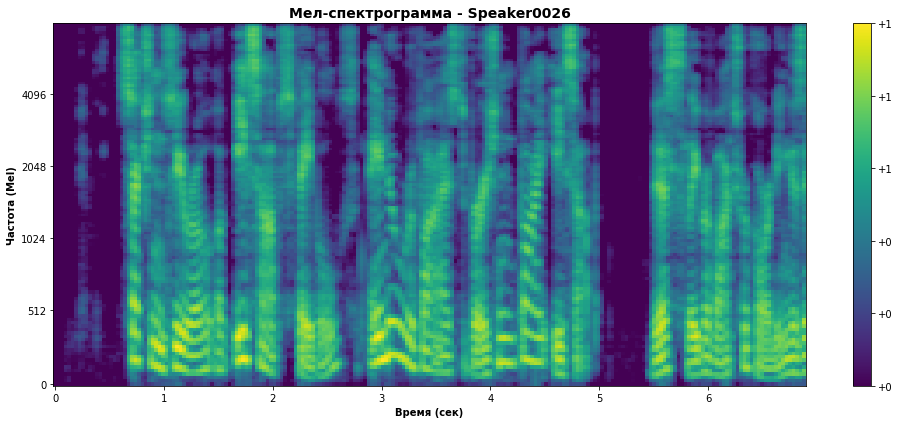


ГЕНЕРАЦИЯ ДАТАСЕТА СПЕКТРОГРАММ
Это займёт время, наберитесь терпения...


Обработка: 100%|██████████| 2499/2499 [00:45<00:00, 54.81it/s]



✓ Успешно обработано: 2499
✗ Ошибок: 0

✓ Форма датасета: (2499, 128, 216, 1)
  - Образцов: 2499
  - Высота (mel bins): 128
  - Ширина (время): 216
  - Каналы: 1
✓ Классов (говорящих): 49

✓ Train: (1999, 128, 216, 1)
✓ Test: (500, 128, 216, 1)
✓ Веса классов вычислены (для борьбы с дисбалансом)

АРХИТЕКТУРА CNN
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 128, 216, 32)      320       
                                                                 
 batch_normalization_28 (Bat  (None, 128, 216, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_21 (Conv2D)          (None, 128, 216, 32)      9248      
                                                                 
 batch_normalization_29 (Bat  (None, 128, 216, 32)     128       
 ch

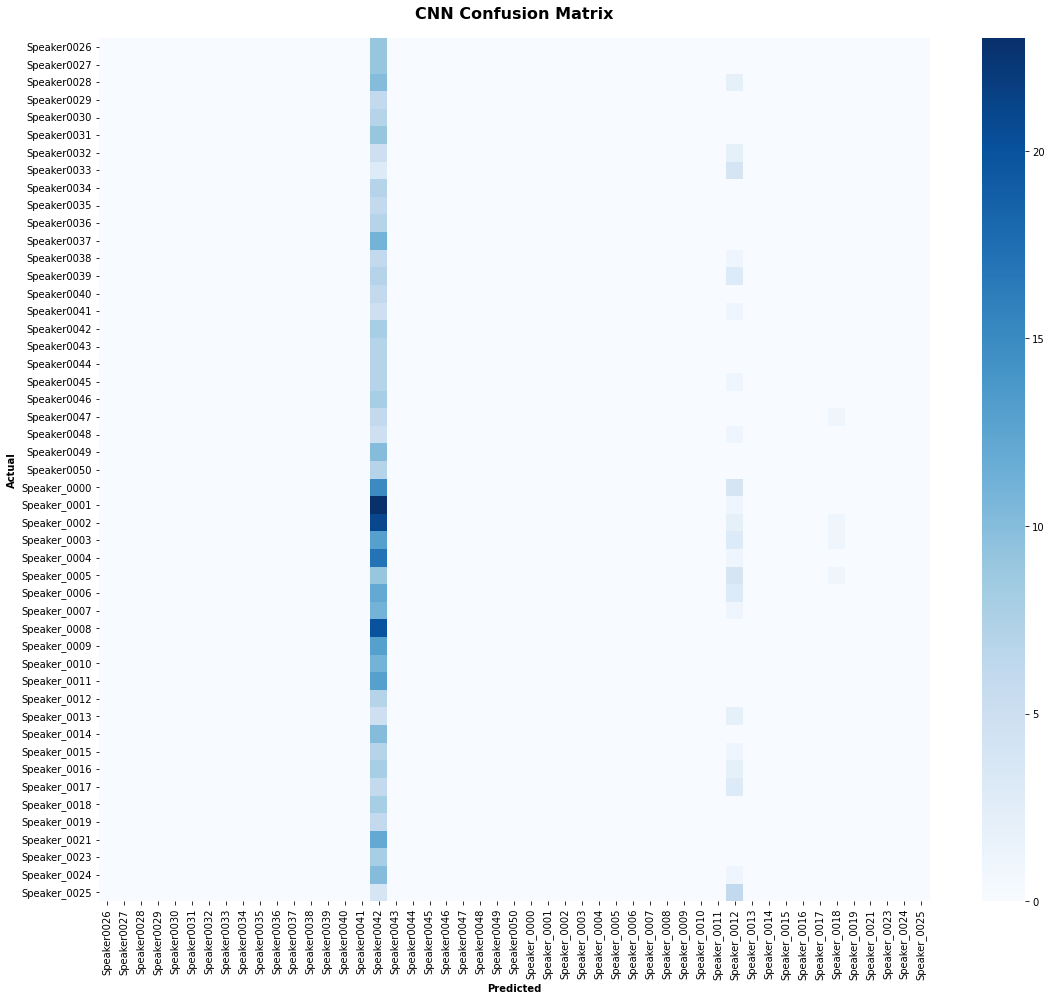

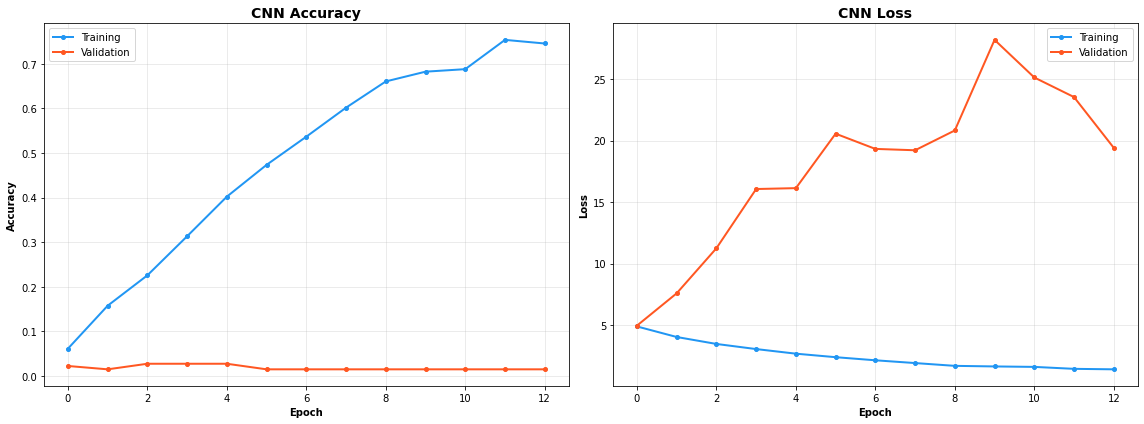


АНАЛИЗ ПЕРЕОБУЧЕНИЯ
Training Accuracy:   0.7455
Validation Accuracy: 0.0150
Test Accuracy:       0.0160
Gap (Train - Val):   0.7305
✗ Переобучение: КРИТИЧЕСКОЕ
⚠ Файл model_results.csv не найден, пропускаем сравнение

✓ ОБУЧЕНИЕ CNN ЗАВЕРШЕНО
Сохранённые файлы:
  - best_cnn_model.h5
  - cnn_label_encoder.pkl
  - spectrogram_params.pkl
  - cnn_training_history.csv
  - cnn_results.csv

✓ Test Accuracy: 0.0160
✓ Gap: 0.7305
✓ Обучено эпох: 13

⚠ Низкая точность. Возможно нужно:
  - Увеличить количество эпох
  - Добавить аугментацию данных
  - Проверить качество спектрограмм


In [7]:
"""
KAGGLE NOTEBOOK 4: CNN на мел-спектрограммах - ИСПРАВЛЕННАЯ ВЕРСИЯ
ТРЕБУЕТ GPU! Settings -> Accelerator -> GPU T4 x2

ЦЕЛЬ: Улучшить распознавание говорящих с нестандартными акцентами
через анализ спектрограмм (как изображений)
"""

import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# GPU ПРОВЕРКА И НАСТРОЙКА
# ============================================================================

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks, regularizers
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import joblib

print("="*80)
print("ПРОВЕРКА GPU")
print("="*80)
print(f"TensorFlow: {tf.__version__}")
print(f"GPU доступно: {tf.config.list_physical_devices('GPU')}")

# Настройка GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✓ GPU настроен: {len(gpus)} устройств")
    except RuntimeError as e:
        print(f"Ошибка GPU: {e}")
else:
    print("⚠ GPU НЕ НАЙДЕН! Включите в Settings -> Accelerator -> GPU T4 x2")
    print("Без GPU обучение займёт ЧАСЫ!")

# ============================================================================
# 1. ПАРАМЕТРЫ СПЕКТРОГРАММ
# ============================================================================

SR = 16000
N_MELS = 128
HOP_LENGTH = 512
N_FFT = 2048
MAX_TIME_STEPS = 216  # ~7 секунд аудио (увеличил с 128)
DURATION = 7  # секунд

print(f"\nПараметры:")
print(f"- Sample Rate: {SR} Hz")
print(f"- N_MELS: {N_MELS}")
print(f"- Длина спектрограммы: {MAX_TIME_STEPS} временных шагов (~{DURATION}s)")

# ============================================================================
# 2. ЗАГРУЗКА ДАННЫХ
# ============================================================================

df_filtered = pd.read_csv(r'D:\VKR\filtered_dataset.csv')
print(f"\n✓ Загружено файлов: {len(df_filtered)}")
print(f"✓ Уникальных говорящих: {df_filtered['speaker_id'].nunique()}")

# ============================================================================
# 3. ФУНКЦИЯ ГЕНЕРАЦИИ МЕЛ-СПЕКТРОГРАММ (ИСПРАВЛЕННАЯ)
# ============================================================================

def audio_to_melspectrogram(file_path, sr=SR, n_mels=N_MELS, 
                           max_time_steps=MAX_TIME_STEPS, duration=DURATION):
    """
    Преобразует аудио в мел-спектрограмму
    ИСПРАВЛЕНО: правильная обработка длительности
    """
    try:
        # Загружаем ТОЧНО duration секунд
        y, _ = librosa.load(file_path, sr=sr, duration=duration)
        
        # Если короче, дополняем нулями
        if len(y) < sr * duration:
            y = np.pad(y, (0, sr * duration - len(y)), mode='constant')
        
        # Генерируем мел-спектрограмму
        mel_spec = librosa.feature.melspectrogram(
            y=y, sr=sr, n_mels=n_mels,
            hop_length=HOP_LENGTH, 
            n_fft=N_FFT,
            fmax=8000  # Голосовые частоты до 8kHz
        )
        
        # В децибелы
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        
        # Нормализация в [0, 1]
        mel_spec_norm = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min() + 1e-8)
        
        # Проверяем размер
        if mel_spec_norm.shape[1] != max_time_steps:
            # Resize до нужного размера
            if mel_spec_norm.shape[1] < max_time_steps:
                pad_width = max_time_steps - mel_spec_norm.shape[1]
                mel_spec_norm = np.pad(mel_spec_norm, ((0, 0), (0, pad_width)), mode='constant')
            else:
                mel_spec_norm = mel_spec_norm[:, :max_time_steps]
        
        return mel_spec_norm
        
    except Exception as e:
        print(f"Ошибка {file_path}: {e}")
        return None

# Визуализация примера
print("\nВизуализация спектрограммы...")
sample_file = df_filtered['file_path'].iloc[0]
sample_speaker = df_filtered['speaker_id'].iloc[0]

mel_spec = audio_to_melspectrogram(sample_file)
print(f"✓ Размер спектрограммы: {mel_spec.shape}")

fig, ax = plt.subplots(figsize=(14, 6))
img = librosa.display.specshow(mel_spec, x_axis='time', y_axis='mel', 
                               sr=SR, hop_length=HOP_LENGTH, ax=ax, cmap='viridis')
ax.set_title(f'Мел-спектрограмма - {sample_speaker}', fontweight='bold', fontsize=14)
ax.set_xlabel('Время (сек)', fontweight='bold')
ax.set_ylabel('Частота (Mel)', fontweight='bold')
fig.colorbar(img, ax=ax, format='%+2.0f')
plt.tight_layout()
plt.savefig('melspectrogram_example.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# 4. ГЕНЕРАЦИЯ ДАТАСЕТА (С ПРОГРЕСС-БАРОМ)
# ============================================================================

print("\n" + "="*80)
print("ГЕНЕРАЦИЯ ДАТАСЕТА СПЕКТРОГРАММ")
print("="*80)
print("Это займёт время, наберитесь терпения...")

spectrograms = []
labels = []
failed_count = 0

for idx, row in tqdm(df_filtered.iterrows(), total=len(df_filtered), desc="Обработка"):
    mel_spec = audio_to_melspectrogram(row['file_path'])
    
    if mel_spec is not None:
        spectrograms.append(mel_spec)
        labels.append(row['speaker_id'])
    else:
        failed_count += 1

print(f"\n✓ Успешно обработано: {len(spectrograms)}")
print(f"✗ Ошибок: {failed_count}")

# Конвертируем в numpy
X_spec = np.array(spectrograms)
y_spec = np.array(labels)

# Добавляем канальное измерение (как RGB изображение, но 1 канал)
X_spec = X_spec[..., np.newaxis]

print(f"\n✓ Форма датасета: {X_spec.shape}")
print(f"  - Образцов: {X_spec.shape[0]}")
print(f"  - Высота (mel bins): {X_spec.shape[1]}")
print(f"  - Ширина (время): {X_spec.shape[2]}")
print(f"  - Каналы: {X_spec.shape[3]}")

# Кодируем метки
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_spec)
num_classes = len(label_encoder.classes_)

print(f"✓ Классов (говорящих): {num_classes}")

# ============================================================================
# 5. РАЗДЕЛЕНИЕ ДАННЫХ
# ============================================================================

X_train, X_test, y_train, y_test = train_test_split(
    X_spec, y_encoded, 
    test_size=0.2, 
    random_state=42,
    stratify=y_encoded
)

print(f"\n✓ Train: {X_train.shape}")
print(f"✓ Test: {X_test.shape}")

# Вычисляем веса классов (для борьбы с дисбалансом)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))
print(f"✓ Веса классов вычислены (для борьбы с дисбалансом)")

# ============================================================================
# 6. CNN АРХИТЕКТУРА (ИСПРАВЛЕННАЯ)
# ============================================================================

def build_cnn_improved(input_shape, num_classes):
    """
    Улучшенная CNN для анализа спектрограмм
    Inspired by VGGNet с адаптацией под аудио
    """
    
    model = models.Sequential([
        # Input
        layers.Input(shape=input_shape),
        
        # Block 1: Извлечение низкоуровневых признаков
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Block 2: Средние признаки
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Block 3: Высокоуровневые признаки
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        
        # Block 4: Детальные паттерны
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.4),
        
        # Dense layers
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        
        # Output
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# Создаём модель
input_shape = (N_MELS, MAX_TIME_STEPS, 1)
model = build_cnn_improved(input_shape, num_classes)

print("\n" + "="*80)
print("АРХИТЕКТУРА CNN")
print("="*80)
model.summary()

# ============================================================================
# 7. КОМПИЛЯЦИЯ И CALLBACKS
# ============================================================================

# Оптимизатор с learning rate schedule
initial_learning_rate = 0.001
optimizer = Adam(learning_rate=initial_learning_rate)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
checkpoint_cb = callbacks.ModelCheckpoint(
    'best_cnn_model.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

early_stopping_cb = callbacks.EarlyStopping(
    monitor='val_accuracy',  # Следим за accuracy, не loss
    patience=10,  # Остановка если 10 эпох нет улучшения
    restore_best_weights=True,
    min_delta=0.001,  # Минимальное улучшение
    verbose=1
)

reduce_lr_cb = callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',  # Следим за accuracy
    factor=0.5,
    patience=4,  # Уменьшаем LR если 4 эпохи нет улучшения
    min_lr=1e-6,
    verbose=1
)

# ============================================================================
# 8. ОБУЧЕНИЕ НА GPU
# ============================================================================

EPOCHS = 50  # Уменьшил со 150
BATCH_SIZE = 64  # Увеличил с 32 для скорости

print("\n" + "="*80)
print("ОБУЧЕНИЕ CNN")
print("="*80)
print(f"Epochs: {EPOCHS}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Training: {len(X_train)} образцов")
print(f"Validation: 20% от training")
print("="*80 + "\n")

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=class_weight_dict,  # Используем веса
    callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr_cb],
    verbose=1
)

# ============================================================================
# 9. ОЦЕНКА МОДЕЛИ
# ============================================================================

# Загружаем лучшую модель
best_model = keras.models.load_model('best_cnn_model.h5')

print("\n" + "="*80)
print("ОЦЕНКА НА ТЕСТОВОЙ ВЫБОРКЕ")
print("="*80)

test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=1)

print(f"\n✓ Test Accuracy: {test_acc:.4f}")
print(f"✓ Test Loss: {test_loss:.4f}")

# Предсказания
y_pred_proba = best_model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)

# Детальные метрики
from sklearn.metrics import classification_report, confusion_matrix

print("\nClassification Report:")
print(classification_report(y_test, y_pred, 
                          target_names=label_encoder.classes_,
                          digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(16, 14))
import seaborn as sns
sns.heatmap(cm, annot=False, cmap='Blues', 
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('CNN Confusion Matrix', fontweight='bold', fontsize=16, pad=20)
plt.xlabel('Predicted', fontweight='bold')
plt.ylabel('Actual', fontweight='bold')
plt.tight_layout()
plt.savefig('cnn_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# 10. ВИЗУАЛИЗАЦИЯ ОБУЧЕНИЯ
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Accuracy
axes[0].plot(history.history['accuracy'], 'o-', color='#2196F3', 
            label='Training', linewidth=2, markersize=4)
axes[0].plot(history.history['val_accuracy'], 'o-', color='#FF5722',
            label='Validation', linewidth=2, markersize=4)
axes[0].set_xlabel('Epoch', fontweight='bold')
axes[0].set_ylabel('Accuracy', fontweight='bold')
axes[0].set_title('CNN Accuracy', fontweight='bold', fontsize=14)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Loss
axes[1].plot(history.history['loss'], 'o-', color='#2196F3',
            label='Training', linewidth=2, markersize=4)
axes[1].plot(history.history['val_loss'], 'o-', color='#FF5722',
            label='Validation', linewidth=2, markersize=4)
axes[1].set_xlabel('Epoch', fontweight='bold')
axes[1].set_ylabel('Loss', fontweight='bold')
axes[1].set_title('CNN Loss', fontweight='bold', fontsize=14)
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('cnn_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# 11. АНАЛИЗ ПЕРЕОБУЧЕНИЯ
# ============================================================================

train_acc_final = history.history['accuracy'][-1]
val_acc_final = history.history['val_accuracy'][-1]
gap = train_acc_final - val_acc_final

print("\n" + "="*80)
print("АНАЛИЗ ПЕРЕОБУЧЕНИЯ")
print("="*80)
print(f"Training Accuracy:   {train_acc_final:.4f}")
print(f"Validation Accuracy: {val_acc_final:.4f}")
print(f"Test Accuracy:       {test_acc:.4f}")
print(f"Gap (Train - Val):   {gap:.4f}")

if gap < 0.05:
    print("✓ Переобучение: МИНИМАЛЬНОЕ")
elif gap < 0.10:
    print("⚠ Переобучение: УМЕРЕННОЕ")
else:
    print("✗ Переобучение: КРИТИЧЕСКОЕ")

# ============================================================================
# 12. СРАВНЕНИЕ С ТРАДИЦИОННЫМИ МОДЕЛЯМИ
# ============================================================================

try:
    traditional_results = pd.read_csv('/kaggle/working/model_results.csv')
    
    print("\n" + "="*80)
    print("СРАВНЕНИЕ CNN С ТРАДИЦИОННЫМИ МОДЕЛЯМИ")
    print("="*80)
    
    comparison = pd.DataFrame([{
        'Model': 'CNN (Spectrograms)',
        'Accuracy': test_acc,
        'Gap': gap
    }])
    
    full_comparison = pd.concat([
        traditional_results[['Model', 'Accuracy']],
        comparison[['Model', 'Accuracy']]
    ], ignore_index=True).sort_values('Accuracy', ascending=False)
    
    print(full_comparison.to_string(index=False))
    
    # График сравнения
    fig, ax = plt.subplots(figsize=(12, 6))
    colors = ['#FF6B6B' if 'CNN' in m else '#4ECDC4' for m in full_comparison['Model']]
    bars = ax.barh(full_comparison['Model'], full_comparison['Accuracy'], 
                   color=colors, alpha=0.8)
    
    ax.set_xlabel('Test Accuracy', fontweight='bold')
    ax.set_title('Сравнение всех моделей', fontweight='bold', fontsize=14)
    ax.grid(axis='x', alpha=0.3)
    
    for bar, value in zip(bars, full_comparison['Accuracy']):
        ax.text(value - 0.02, bar.get_y() + bar.get_height()/2, 
                f'{value:.4f}', va='center', ha='right', 
                fontweight='bold', color='white')
    
    plt.tight_layout()
    plt.savefig('all_models_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
except FileNotFoundError:
    print("⚠ Файл model_results.csv не найден, пропускаем сравнение")

# ============================================================================
# 13. СОХРАНЕНИЕ АРТЕФАКТОВ
# ============================================================================

joblib.dump(label_encoder, 'cnn_label_encoder.pkl')

spectrogram_params = {
    'sr': SR,
    'n_mels': N_MELS,
    'hop_length': HOP_LENGTH,
    'n_fft': N_FFT,
    'max_time_steps': MAX_TIME_STEPS,
    'duration': DURATION
}
joblib.dump(spectrogram_params, 'spectrogram_params.pkl')

history_df = pd.DataFrame(history.history)
history_df.to_csv('cnn_training_history.csv', index=False)

cnn_results = pd.DataFrame([{
    'Model': 'CNN',
    'Train_Acc': train_acc_final,
    'Val_Acc': val_acc_final,
    'Test_Acc': test_acc,
    'Test_Loss': test_loss,
    'Gap': gap,
    'Epochs_Trained': len(history.history['accuracy']),
    'Best_Val_Acc': max(history.history['val_accuracy'])
}])
cnn_results.to_csv('cnn_results.csv', index=False)

print("\n" + "="*80)
print("✓ ОБУЧЕНИЕ CNN ЗАВЕРШЕНО")
print("="*80)
print("Сохранённые файлы:")
print("  - best_cnn_model.h5")
print("  - cnn_label_encoder.pkl")
print("  - spectrogram_params.pkl")
print("  - cnn_training_history.csv")
print("  - cnn_results.csv")
print(f"\n✓ Test Accuracy: {test_acc:.4f}")
print(f"✓ Gap: {gap:.4f}")
print(f"✓ Обучено эпох: {len(history.history['accuracy'])}")

if test_acc > 0.85:
    print("\n🎉 ОТЛИЧНЫЙ РЕЗУЛЬТАТ! CNN работает корректно!")
elif test_acc > 0.70:
    print("\n✓ Хороший результат. CNN обучена успешно.")
else:
    print("\n⚠ Низкая точность. Возможно нужно:")
    print("  - Увеличить количество эпох")
    print("  - Добавить аугментацию данных")
    print("  - Проверить качество спектрограмм")

print("="*80)

In [1]:
import secrets
print(secrets.token_hex(32))
# Скопируйте вывод

41d316b6de283a74cdef7f61e6af892aa94ef21884a2e1fc0993ffa5f74a3e32
